In [1]:
# pip install xgboost

     -------------------------------------- 99.8/99.8 MB 892.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor

In [2]:
# Read in buoy data
file = "C:/Users/rache/Documents/University of Southern California/2023-2024 Year 4/GEOL 599 Environmental data science/data/HW8_buoy_data.xlsx" #note on path
buoy_all = pd.read_excel(file)

In [3]:
# Select only needed columns and rename them
buoy = buoy_all.loc[:,['WVHT','DPD','APD','MWD','WTMP']]
buoy = buoy.rename(columns={'WVHT':'height','DPD':'dom pd','APD':'avg pd','MWD':'dir','WTMP':'temp'})
buoy.head()

,height,dom pd,avg pd,dir,temp
0,1.12,12.50,7.69,269,15.3
1,1.16,11.76,7.34,272,15.3
2,1.20,12.50,7.08,268,15.3
3,1.25,10.53,7.33,268,15.4
4,1.27,10.53,7.57,268,15.5


In [4]:
# Drop rows with no data (cell value = 99)
buoy[(buoy['height']==99)|(buoy['dom pd']==99)|(buoy['avg pd']==99)|(buoy['dir']==99)|(buoy['temp']==99)] #See rows with no data
buoy= buoy.drop(buoy[buoy['height']==99].index)

In [5]:
# Convert data to numpy array
X = buoy.loc[:,['dom pd','avg pd','dir','temp']].to_numpy()
X

array([[ 12.5 ,   7.69, 269.  ,  15.3 ],
       [ 11.76,   7.34, 272.  ,  15.3 ],
       [ 12.5 ,   7.08, 268.  ,  15.3 ],
       ...,
       [ 13.33,  10.5 , 268.  ,  16.8 ],
       [ 14.29,  10.32, 271.  ,  16.8 ],
       [ 12.5 ,  10.54, 271.  ,  16.9 ]])

In [6]:
# Convert data to numpy array
y = buoy.loc[:,'height'].to_numpy()
y

array([1.12, 1.16, 1.2 , ..., 1.79, 1.66, 1.7 ])

In [7]:
# Split the data into training, validation, and test datasets (75:10:15 split)
Xtr, X1 , ytr, y1 = tts(X, y, test_size= 0.25) #split into 75% training, 25% everything else
Xva, Xte, yva, yte = tts(X1, y1, test_size= 0.6)

In [8]:
# Fit linear ODE as baseline model for comparison
lin = linear_model.LinearRegression()
lin.fit(Xtr, ytr)
print(lin.score(Xtr,ytr))
print(lin.score(Xva,yva))
print(lin.score(Xte,yte))

0.30022271286462443
0.2842690899136273
0.26650546435020894


In [32]:
# Fit boosted regression tree model to buoy data
bst = XGBRegressor(n_estimators=25, learning_rate=0.6,early_stopping_rounds=8)
bst.fit(Xtr, ytr, eval_set=[(Xva, yva)])
print(bst.score(Xtr,ytr))
print(bst.score(Xva,yva))
# Validation data indicates optimal learning rate is 0.6 and early stopping rounds is 8.

[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[2]	validation_0-rmse:0.34056
[3]	validation_0-rmse:0.32957
[4]	validation_0-rmse:0.32581
[5]	validation_0-rmse:0.32195
[6]	validation_0-rmse:0.31937
[7]	validation_0-rmse:0.31805
[8]	validation_0-rmse:0.31534
[9]	validation_0-rmse:0.30907
[10]	validation_0-rmse:0.30897
[11]	validation_0-rmse:0.30782
[12]	validation_0-rmse:0.30874
[13]	validation_0-rmse:0.30975
[14]	validation_0-rmse:0.30926
[15]	validation_0-rmse:0.31063
[16]	validation_0-rmse:0.30946
[17]	validation_0-rmse:0.30895
[18]	validation_0-rmse:0.30842
[19]	validation_0-rmse:0.30810
0.7488295444610324
0.6563636693766378


In [29]:
# Look at model for test dataset.
print(bst.score(Xte,yte))

0.6535272384637232


In [34]:
# Find boosted regression tree loss function
bst.objective

'reg:squarederror'

In [36]:
# Summarize the 2 models' scores and errors
print("Linear score:", lin.score(Xte,yte).round(3))
print("Linear MSE:", mse(yte, lin.predict(Xte)).round(3))
print("Boosted regression tree score:", bst.score(Xte,yte).round(3))
print("Boosted regression tree MSE:", mse(yte, bst.predict(Xte)).round(3))

Linear score: 0.267
Linear MSE: 0.179
Boosted regression tree score: 0.654
Boosted regression tree MSE: 0.085


In [ ]:
# 1.) Comparing a baseline linear model and the boosted regression tree model, the latter performs better than the former.The training, validation, and test scores for the linear model are 0.300, 0.284, and 0.267 while the ones for the boosted regression tree model are 0.749, 0.656, and 0.654. The tree model scores for all 3 datasets are higher than the corresponding ones for the linear model.
# 2.) The cost function for the linear model is ordinary least squares. The one for the boosted regression tree is mean squared error.
# 3.) I optimized learning rate and early stopping rounds using the validation dataset score. I adjusted learning rate to maximize the validation dataset score (learning rate = 0.6) and increased the stopping rounds until the score no longer increased significantly (rounds = 8).

In [37]:
# Generate set of boosted regression tree models with different # of iterations
b2 = XGBRegressor(n_estimators=2, learning_rate=0.6,early_stopping_rounds=8)
b10 = XGBRegressor(n_estimators=10, learning_rate=0.6,early_stopping_rounds=8)
b50 = XGBRegressor(n_estimators=50, learning_rate=0.6,early_stopping_rounds=8)
b100 = XGBRegressor(n_estimators=100, learning_rate=0.6,early_stopping_rounds=8)
b250 = XGBRegressor(n_estimators=250, learning_rate=0.6,early_stopping_rounds=8)
b500 = XGBRegressor(n_estimators=500, learning_rate=0.6,early_stopping_rounds=8)
b1000 = XGBRegressor(n_estimators=1000, learning_rate=0.6,early_stopping_rounds=8)

In [39]:
# Fit all the new models
b2.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b10.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b50.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b100.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b250.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b500.fit(Xtr,ytr,eval_set=[(Xva, yva)])
b1000.fit(Xtr,ytr,eval_set=[(Xva, yva)])

[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[2]	validation_0-rmse:0.34056
[3]	validation_0-rmse:0.32957
[4]	validation_0-rmse:0.32581
[5]	validation_0-rmse:0.32195
[6]	validation_0-rmse:0.31937
[7]	validation_0-rmse:0.31805
[8]	validation_0-rmse:0.31534
[9]	validation_0-rmse:0.30907
[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[2]	validation_0-rmse:0.34056
[3]	validation_0-rmse:0.32957
[4]	validation_0-rmse:0.32581
[5]	validation_0-rmse:0.32195
[6]	validation_0-rmse:0.31937
[7]	validation_0-rmse:0.31805
[8]	validation_0-rmse:0.31534
[9]	validation_0-rmse:0.30907
[10]	validation_0-rmse:0.30897
[11]	validation_0-rmse:0.30782
[12]	validation_0-rmse:0.30874
[13]	validation_0-rmse:0.30975
[14]	validation_0-rmse:0.30926
[15]	validation_0-rmse:0.31063
[16]	validation_0-rmse:0.30946
[17]	validation_0-rmse:0.30895
[18]	validation_0-rmse:0.30842
[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=8,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.6, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
# Put all the training and validation MSEs from the above models into a dataframe
it_num= [2,10,25,50,100,250,500,1000]
mse1= [mse(ytr, b2.predict(Xtr)), mse(ytr, b10.predict(Xtr)), mse(ytr, bst.predict(Xtr)), mse(ytr, b50.predict(Xtr)), mse(ytr, b100.predict(Xtr)), mse(ytr, b250.predict(Xtr)), mse(ytr, b500.predict(Xtr)), mse(ytr, b1000.predict(Xtr))]
mse2= [mse(yva, b2.predict(Xva)), mse(yva, b10.predict(Xva)), mse(yva, bst.predict(Xva)), mse(yva, b50.predict(Xva)), mse(yva, b100.predict(Xva)), mse(yva, b250.predict(Xva)), mse(yva, b500.predict(Xva)), mse(yva, b1000.predict(Xva))]
MSE_data= {'number of iterations':it_num, 'training data MSE':mse1, 'validation data MSE':mse2}
MSE_df= pd.DataFrame(MSE_data)

In [42]:
MSE_df

,number of iterations,training data MSE,validation data MSE
0,2,0.117268,0.123654
1,10,0.074253,0.095525
2,25,0.071364,0.094751
3,50,0.071364,0.094751
4,100,0.071364,0.094751
5,250,0.071364,0.094751
6,500,0.071364,0.094751
7,1000,0.071364,0.094751


In [44]:
# Turn MSE dataframe to long format
MSE_df = MSE_df.rename(columns= {'training data MSE':'training', 'validation data MSE':'validation'})
MSE_df_long = pd.melt(MSE_df, id_vars= ['number of iterations'], value_vars= ['training','validation'])
MSE_df_long

,number of iterations,variable,value
0,2,training,0.117268
1,10,training,0.074253
2,25,training,0.071364
3,50,training,0.071364
4,100,training,0.071364
5,250,training,0.071364
6,500,training,0.071364
7,1000,training,0.071364
8,2,validation,0.123654
9,10,validation,0.095525


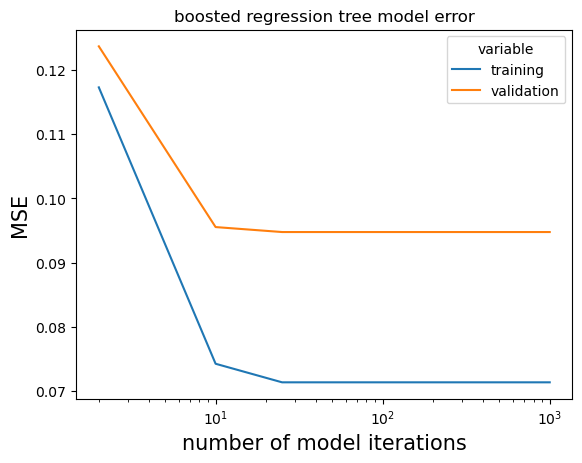

In [47]:
# 4.) Plot the number of iterations vs. the MSEs
plot= sns.lineplot(data=MSE_df_long, x='number of iterations', y='value', hue= 'variable')
plot.set_title("boosted regression tree model error")
plt.xscale('log')
plt.xlabel("number of model iterations", fontsize= 15)
plt.ylabel("MSE", fontsize= 15)
plt.show()

In [ ]:
# 5.) I do not have any evidence of overfitting because the validation data errors did not increase with increasing iterations.

In [65]:
bst2 = XGBRegressor(n_estimators=35, learning_rate=0.6,early_stopping_rounds=10)
bst2.fit(Xtr, ytr, eval_set=[(Xva, yva)])
print(bst2.score(Xtr,ytr))
print(bst2.score(Xva,yva))
print(bst2.score(Xte,yte))

[0]	validation_0-rmse:0.38662
[1]	validation_0-rmse:0.35164
[2]	validation_0-rmse:0.34056
[3]	validation_0-rmse:0.32957
[4]	validation_0-rmse:0.32581
[5]	validation_0-rmse:0.32195
[6]	validation_0-rmse:0.31937
[7]	validation_0-rmse:0.31805
[8]	validation_0-rmse:0.31534
[9]	validation_0-rmse:0.30907
[10]	validation_0-rmse:0.30897
[11]	validation_0-rmse:0.30782
[12]	validation_0-rmse:0.30874
[13]	validation_0-rmse:0.30975
[14]	validation_0-rmse:0.30926
[15]	validation_0-rmse:0.31063
[16]	validation_0-rmse:0.30946
[17]	validation_0-rmse:0.30895
[18]	validation_0-rmse:0.30842
[19]	validation_0-rmse:0.30810
[20]	validation_0-rmse:0.30673
[21]	validation_0-rmse:0.30739
[22]	validation_0-rmse:0.30611
[23]	validation_0-rmse:0.30632
[24]	validation_0-rmse:0.30612
[25]	validation_0-rmse:0.30637
[26]	validation_0-rmse:0.30624
[27]	validation_0-rmse:0.30591
[28]	validation_0-rmse:0.30673
[29]	validation_0-rmse:0.30637
[30]	validation_0-rmse:0.30609
[31]	validation_0-rmse:0.30572
[32]	validation_0-

In [ ]:
# 6.) After changing the stopping to a tolerance of 10, the optimal boosting iterations seems to be 35.